Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 1.5223 - accuracy: 0.3585
Epoch 1: val_accuracy improved from -inf to 0.53043, saving model to best_model.keras
58/58 [==============================] - 1s 6ms/step - loss: 1.5223 - accuracy: 0.3585 - val_loss: 1.1943 - val_accuracy: 0.5304
Epoch 2/50
38/58 [==================>...........] - ETA: 0s - loss: 1.0477 - accuracy: 0.5132
Epoch 2: val_accuracy improved from 0.53043 to 0.70000, saving model to best_model.keras
58/58 [==============================] - 0s 4ms/step - loss: 1.0163 - accuracy: 0.5408 - val_loss: 0.8561 - val_accuracy: 0.7000
Epoch 3/50
48/58 [=======================>......] - ETA: 0s - loss: 0.7638 - accuracy: 0.6198
Epoch 3: val_accuracy did not improve from 0.70000
58/58 [==============================] - 0s 4ms/step - loss: 0.7506 - accuracy: 0.6251 - val_loss: 0.8300 - val_accuracy: 0.6826
Epoch 4/50
41/58 [====================>.........] - ETA: 0s - loss: 0.6351 - accuracy: 0.6966
Epoch 4: va

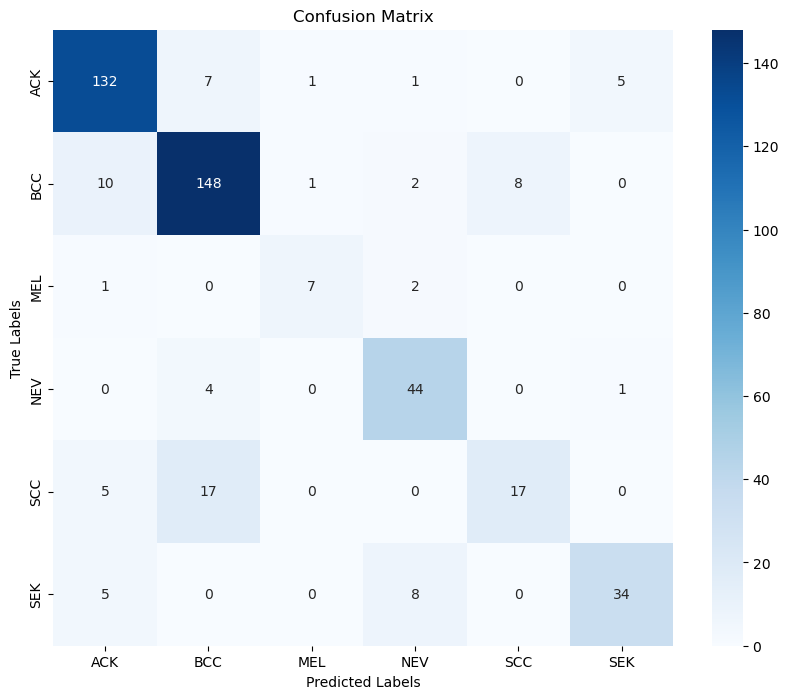

15/15 [==============================] - 0s 1ms/step
AUC for class ACK: 0.9696
AUC for class BCC: 0.9480
AUC for class MEL: 0.9822
AUC for class NEV: 0.9825
AUC for class SCC: 0.8929
AUC for class SEK: 0.9673
Macro-Averaged AUC: 0.9571
Micro-Averaged AUC: 0.9701


In [4]:
# neural network fusion of metadata and features for multiclass

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Read and process the data
df = pd.read_csv('../dataset/filled_with_features.csv', index_col=0, low_memory=False)

# Target and features
y = df['diagnostic']
df = df.drop(columns=['diagnostic'])
X_metadata = df.iloc[:, :22]
X_features = df.iloc[:, 22:1942]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_metadata = pd.get_dummies(X_metadata, drop_first=True)

# Scale metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data with a validation set
X_train_meta, X_test_meta, X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_metadata, X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Define the metadata model
input_meta = Input(shape=(X_train_meta.shape[1],))
x_meta = Dense(64, activation='relu')(input_meta)
x_meta = Dense(32, activation='relu')(x_meta)
metadata_model = Model(inputs=input_meta, outputs=x_meta)

# Define the features model
input_feat = Input(shape=(X_train_feat.shape[1],))
x_feat = Dense(128, activation='relu')(input_feat)
x_feat = Dense(64, activation='relu')(x_feat)
features_model = Model(inputs=input_feat, outputs=x_feat)

# Merge the two models
merged = concatenate([metadata_model.output, features_model.output])
x = Dense(64, activation='relu')(merged)
x = Dense(32, activation='relu')(x)
output = Dense(len(np.unique(y_encoded)), activation='softmax')(x)  # Ensure correct output size

final_model = Model(inputs=[metadata_model.input, features_model.input], outputs=output)

# Compile model
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Checkpoint to save the best model
checkpoint_filepath = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with validation data and class weights
final_model.fit(
    [X_train_meta, X_train_feat], y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_test_meta, X_test_feat], y_test),
    class_weight=class_weights_dict,
    callbacks=[model_checkpoint]
)
import tensorflow as tf
final_model = tf.keras.models.load_model("best_model.keras")

# Evaluate on test set
loss, accuracy = final_model.evaluate([X_test_meta, X_test_feat], y_test)
print(f'Test Accuracy: {accuracy}')


# Make predictions
y_pred = np.argmax(final_model.predict([X_test_meta, X_test_feat]), axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass ROC-AUC computation
y_test_binarized = label_binarize(y_test, classes=range(len(le.classes_)))

# Get predicted probabilities
y_pred_proba = final_model.predict([X_test_meta, X_test_feat])

# Calculate ROC-AUC for each class
class_auc = {}
for i, class_name in enumerate(le.classes_):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    class_auc[class_name] = auc
    print(f"AUC for class {class_name}: {auc:.4f}")

# Macro-average AUC: Average of AUCs across all classes
macro_auc = np.mean(list(class_auc.values()))
print(f"Macro-Averaged AUC: {macro_auc:.4f}")

# Micro-average AUC: Aggregate true positives and false positives across all classes
micro_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="micro")
print(f"Micro-Averaged AUC: {micro_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.95      0.93       242
   malignant       0.94      0.91      0.93       218

    accuracy                           0.93       460
   macro avg       0.93      0.93      0.93       460
weighted avg       0.93      0.93      0.93       460



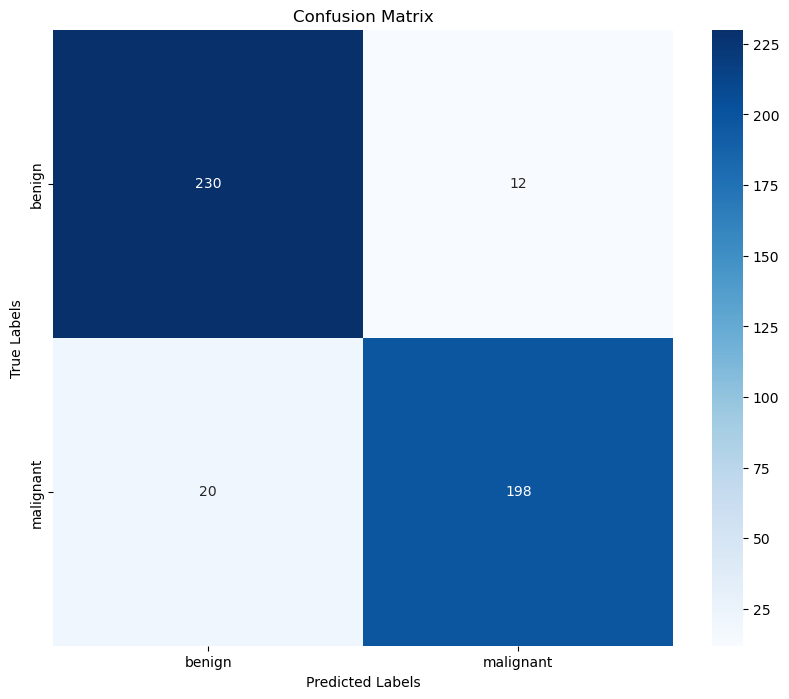

Binary Classification AUC: 0.9722


In [5]:
# binary classification for above code

for i in range(len(y_test)):
    if y_test[i] in [1, 2, 4]:
        y_test[i] = 1
    else:
        y_test[i] = 0
    if y_pred[i] in [1, 2, 4]:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['benign', 'malignant']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score

# Remap the true labels and predicted probabilities for binary classification
# Map: 1, 2, 4 -> malignant (1), others -> benign (0)
y_test_binary = np.array([1 if label in [1, 2, 4] else 0 for label in y_test])
y_pred_binary_proba = np.sum(y_pred_proba[:, [1, 2, 4]], axis=1)  # Sum probabilities of classes 1, 2, 4 for malignant

# Calculate ROC-AUC for the binary classification
binary_auc = roc_auc_score(y_test_binary, y_pred_binary_proba)
print(f"Binary Classification AUC: {binary_auc:.4f}")

Test Accuracy: 0.9521739130434783
Classification Report:
              precision    recall  f1-score   support

         ACK       0.98      0.97      0.97       146
         BCC       0.94      0.96      0.95       169
         MEL       1.00      0.90      0.95        10
         NEV       1.00      0.98      0.99        49
         SCC       0.84      0.79      0.82        39
         SEK       0.94      0.98      0.96        47

    accuracy                           0.95       460
   macro avg       0.95      0.93      0.94       460
weighted avg       0.95      0.95      0.95       460



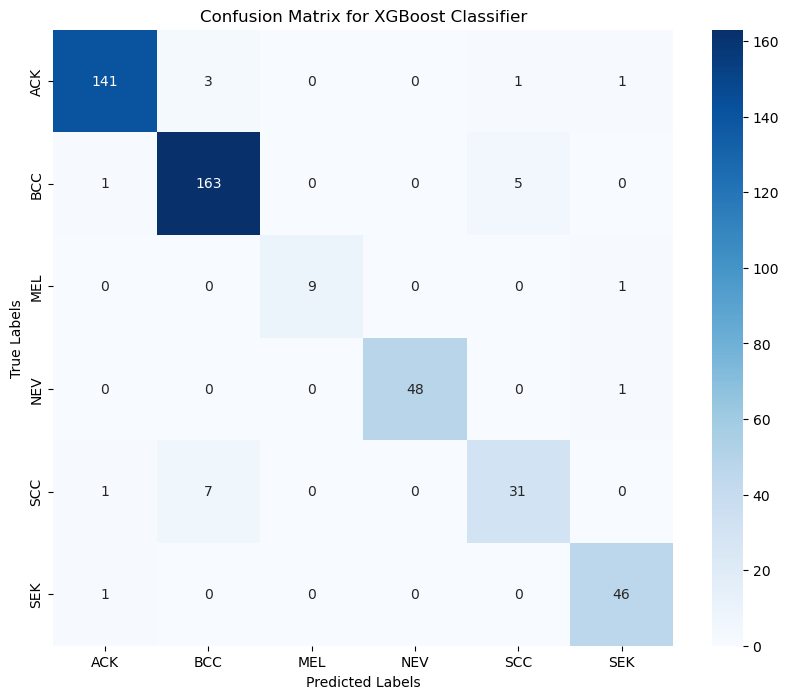

AUC for class ACK: 0.9987
AUC for class BCC: 0.9938
AUC for class MEL: 0.9998
AUC for class NEV: 1.0000
AUC for class SCC: 0.9767
AUC for class SEK: 0.9991
Macro-Averaged AUC: 0.9947
Micro-Averaged AUC: 0.9966


In [6]:
# metadata with probability multiclass

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Combine train and test data
df = pd.read_csv('../dataset/final_metadata_with_probability.csv')

# Define function to convert booleans to strings
def convert_bool_to_str(value):
    if isinstance(value, bool):
        return "True" if value else "False"
    return value

# Apply the conversion function to each column
for col in df.columns:
    df[col] = df[col].map(convert_bool_to_str)

# Now df is shuffled and ready for further processing

# Target and features
y = df['diagnostic']
df = df.drop(columns=['diagnostic'])
X_metadata = df

y_encoded = y

# One-hot encode categorical metadata
X_metadata = pd.get_dummies(X_metadata, drop_first=True)

# Scale metadata
scaler = StandardScaler()
X_metadata = scaler.fit_transform(X_metadata)

# Split data with a validation set
X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_metadata, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Define and train the XGBoost classifier
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train_meta, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_meta)
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK'], yticklabels=['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Get predicted probabilities
y_pred_proba = model.predict_proba(X_test_meta)

# Binarize the true labels for multiclass ROC-AUC computation
classes = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
y_test_binarized = label_binarize(y_test, classes=range(len(classes)))

# Calculate ROC-AUC for each class
class_auc = {}
for i, class_name in enumerate(classes):
    auc = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    class_auc[class_name] = auc
    print(f"AUC for class {class_name}: {auc:.4f}")

# Macro-average AUC: Average of AUCs across all classes
macro_auc = np.mean(list(class_auc.values()))
print(f"Macro-Averaged AUC: {macro_auc:.4f}")

# Micro-average AUC: Aggregate true positives and false positives across all classes
micro_auc = roc_auc_score(y_test_binarized, y_pred_proba, average="micro")
print(f"Micro-Averaged AUC: {micro_auc:.4f}")

Test Accuracy: 0.9847826086956522
Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.98      0.99       242
   malignant       0.98      0.99      0.98       218

    accuracy                           0.98       460
   macro avg       0.98      0.98      0.98       460
weighted avg       0.98      0.98      0.98       460



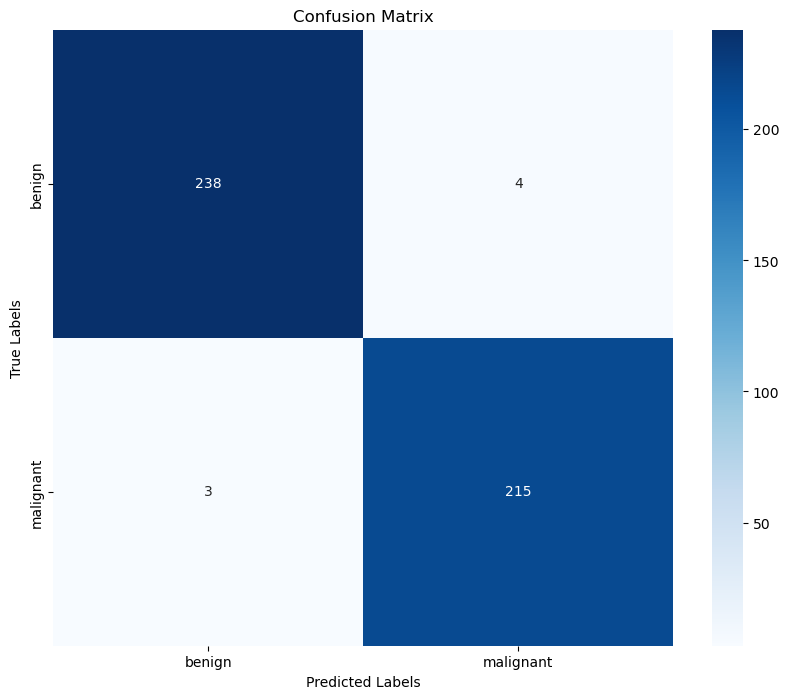

Binary Classification AUC: 0.9991


In [7]:
# metadata with probability binary

y_test = np.array(y_test)
y_pred = np.array(y_pred)

for i in range(len(y_test)):
    if y_test[i] in [1, 2, 4]:
        y_test[i] = 1
    else:
        y_test[i] = 0
    if y_pred[i] in [1, 2, 4]:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['benign', 'malignant']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score

# Convert the predicted probabilities for binary classification
y_pred_proba = model.predict_proba(X_test_meta)

# Map: 1, 2, 4 -> malignant (1), others -> benign (0)
y_test_binary = np.array([1 if label in [1, 2, 4] else 0 for label in y_test])
y_pred_binary_proba = np.sum(y_pred_proba[:, [1, 2, 4]], axis=1)  # Sum probabilities of classes 1, 2, 4 for malignant

# Calculate ROC-AUC for the binary classification
binary_auc = roc_auc_score(y_test_binary, y_pred_binary_proba)
print(f"Binary Classification AUC: {binary_auc:.4f}")
